# Forecasting
Use the forecasting tool along with imported mc samples to forecast short and long term emissions in Canada under different scenarios

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import geopandas as gpd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be sl

In [2]:
from fig_package.forecast import *
from fig_package.fig_project.project_starts import *
from fig_package.fig_sample.road_clean_sample import *
from fig_package.fig_helper.helper import *
from fig_package.fig_sample.house_clean_sample import *

## Generic forecast test: british columbia
run generic forecast using module. Clean and filter the samples for a given province, then run.

<b>IMPORT AND PREPARE SAMPLE</b>

In [3]:
# import mcs samples and prov da info
bc_mc = pd.read_csv('C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/bc/inf_mc_samples_bc.csv')
hs = HouseSample(master='C:/Users/Keagan Rankin/')
hs.province_name = 'british_columbia'
prov_da = hs.get_prov_da(prov_name=hs.province_name, shapefile_path=hs.shapefile_path, 
                            census_data_path=hs.path + 'da_census_data_reduced/' + hs.prov_da_file_map[hs.province_name], dropna=True)

# road clean filter extreme outliers
rc = RoadClean(master='C:/Users/Keagan Rankin/')
rc.province_name = 'british_columbia'
roads_clean = rc.full_road_clean_map()
road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})
handy = Helper()
road_filt = handy.drop_outliers_iqr(road_filt, 'LENGTH_GEO', f=3)
road_filt.index

[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  496


Int64Index([59010124, 59010128, 59010129, 59010130, 59010131, 59010132,
            59010133, 59010135, 59010146, 59010147,
            ...
            59570227, 59590019, 59590020, 59590021, 59590022, 59590023,
            59590024, 59590025, 59590026, 59590038],
           dtype='int64', name='DAUID', length=7075)

In [7]:
# prep sample
forecaster = Forecast()
bc_samps_p = forecaster.prep_sample(samp=bc_mc, n_iters=500, prov_da=prov_da, road_filter_index=road_filt.index, 
                                    sf=[0.0, 1.0], mm=[0.0, 1.0], hr=[0.0, 1.0])
bc_samps_p

DAUID  house_ghg_pp  road_ghg_pp  water_inf_ghg_pp  iter  \
0        59010124  24319.512810  4259.333280        263.946481     0   
2639535  59010124  24505.828794  4549.846769        256.419946     1   
699913   59010124  23537.258394  4287.006116        256.555936     2   
2329620  59010124  24876.847301  4202.788806        261.862762     3   
605142   59010124  23294.798644  4458.241809        259.777686     4   
...           ...           ...          ...               ...   ...   
3279977  59590038  24314.707578  5214.808133       1205.971795   495   
264559   59590038  22942.367347  4787.444884       1189.221630   496   
1701461  59590038  23101.307711  4697.247652       1176.881413   497   
3185816  59590038  24934.780051  4705.501382       1226.972519   498   
257457   59590038  23494.657202  4641.069100       1189.221630   499   

         tot_pd_check_count  
0                     245.0  
2639535               245.0  
699913                245.0  
2329620               245.0  
605142                245.0  
...                     ...  
3279977               180.0  
264559                180.0  
1701461               180.0  
3185816               180.0  
257457                180.0  

[3413500 rows x 6 columns]

<b>RUN MATFLOW</b>

In [8]:
# get projected starts
from fig_package.fig_project.project_starts import *
p_starter = ProjectStarts()

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


In [19]:
bc_starts = p_starter.provincial_starts('british_columbia')
bc_starts[0]#['british_columbia_d'])

british_columbia_d  british_columbia_d_add
Year                                            
2022               46679            48957.253262
2023               44477            50484.277269
2024               43286            58385.036789
2025               46111            80176.913374
2026               48042           111375.333333
2027               48630           141230.753293
2028               48767           160334.629877
2029               48781           169440.389398
2030               48389           172777.413405

In [13]:
bc_f = forecaster.matflow_generic(samps_p=bc_samps_p, starts=np.array(bc_starts[0]['british_columbia_d']),
                                  it=500, infill_percent=0.3)

  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

In [25]:
bic_scenario_c = pd.concat(bc_f)
bic_scenario_c

DAUID  house_ghg_pp  road_ghg_pp  water_inf_ghg_pp  iter  \
2509322  59150590  17365.775957   686.475932        146.215996     0   
2631400  59350190  16492.395507  1351.241635        249.333113     0   
2035418  59090559  17205.967902   778.054080        187.740428     0   
3523699  59153742  13264.808592   725.061594        135.243238     0   
201979   59153257  15252.976071   673.746715         86.033774     0   
...           ...           ...          ...               ...   ...   
2939490  59151818  16026.031005     0.000000          0.000000   499   
3317992  59153897   8808.606547     0.000000          0.000000   499   
2768422  59151842  10215.443310     0.000000          0.000000   499   
558123   59270054  22541.981460     0.000000          0.000000   499   
2333128  59152477  13997.829636     0.000000          0.000000   499   

         tot_pd_check_count  year  
2509322               215.0     0  
2631400               905.0     0  
2035418               290.0     0  
3523699               250.0     0  
201979                310.0     0  
...                     ...   ...  
2939490                95.0     8  
3317992               285.0     8  
2768422               250.0     8  
558123                250.0     8  
2333128               255.0     8  

[772545 rows x 7 columns]

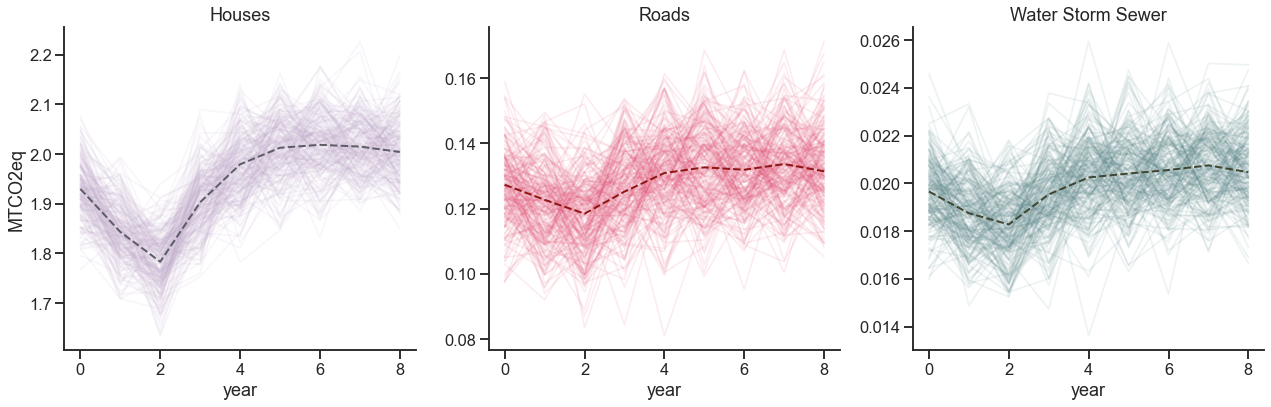

In [26]:
bic_scenario_c = bic_scenario_c.join(prov_da[['DAUID','pop_2021']].set_index('DAUID'), on='DAUID')
bic_scenario_c['house_ghg'] = bic_scenario_c['house_ghg_pp']*bic_scenario_c['pop_2021']*10**-3
bic_scenario_c['road_ghg'] = bic_scenario_c['road_ghg_pp']*bic_scenario_c['pop_2021']*10**-3
bic_scenario_c['water_ghg'] = bic_scenario_c['water_inf_ghg_pp']*bic_scenario_c['pop_2021']*10**-3
bic_scenario_c = bic_scenario_c.drop(['house_ghg_pp','road_ghg_pp','water_inf_ghg_pp'], axis=1)
bic_scenario_c['house_road_ghg'] = bic_scenario_c['house_ghg'] + bic_scenario_c['road_ghg']
bic_scenario_c['all_ghg'] = bic_scenario_c['house_ghg'] + bic_scenario_c['road_ghg'] + bic_scenario_c['water_ghg']

# Plot outputs year by year.
fig, ax = plt.subplots(1,3, figsize=(18,6))
for i in range(0,200):
    plotr = bic_scenario_c[bic_scenario_c['iter'] == i].groupby('year').sum()
    sns.lineplot(ax=ax[0], data=plotr, x=plotr.index, y=plotr['house_ghg']*10**-6,#.cumsum(), 
                 color='#C3ACCE', alpha=0.1, linewidth=1.7)
    sns.lineplot(ax=ax[1], data=plotr, x=plotr.index, y=plotr['road_ghg']*10**-6,#.cumsum(), 
                 color='#E34A6F', alpha=0.1, linewidth=1.7)
    sns.lineplot(ax=ax[2], data=plotr, x=plotr.index, y=plotr['water_ghg']*10**-6,#.cumsum(),
                 color='#538083', alpha=0.1, linewidth=1.7)
    

# Plot median
plotr_m = bic_scenario_c.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
sns.lineplot(ax=ax[0], data=plotr_m, x=plotr_m.index, y=plotr_m['house_ghg']*10**-6,#.cumsum(), 
                color='#5C5D67', alpha=1, linewidth=2, linestyle='dashed')
sns.lineplot(ax=ax[1], data=plotr_m, x=plotr_m.index, y=plotr_m['road_ghg']*10**-6,#.cumsum(), 
                color='#8E1715', alpha=1, linewidth=2, linestyle='dashed')
sns.lineplot(ax=ax[2], data=plotr_m, x=plotr_m.index, y=plotr_m['water_ghg']*10**-6,#.cumsum(),
                color='#3F4732', alpha=1, linewidth=2, linestyle='dashed')


ax[0].spines[['top','right']].set_visible(False)
ax[1].spines[['top','right']].set_visible(False)
ax[2].spines[['top','right']].set_visible(False)
ax[0].set_ylabel('MTCO2eq')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_title('Houses')
ax[1].set_title('Roads')
ax[2].set_title('Water Storm Sewer')
#ax.set_ylabel('kgCO2eq/person')
plt.tight_layout()

In [10]:
# import prep sample
forecaster = Forecast()
forecaster.province_name = 'newfoundland'
p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
mc = pd.read_csv(p + 'nl' + '/inf_mc_samples_' + 'nl' + '.csv')
samps_p = forecaster.prep_sample_with_imports(samp=mc, sf=[0.0,1.0], mm=[0.0, 1.0], hr=[0.0,1.0], iters=500)

# get projected starts
p_starter = ProjectStarts()
s_starts = p_starter.provincial_starts('newfoundland')
#print(s_starts)
print(samps_p)

# run generic matflow
prov_f = forecaster.matflow_generic(samps_p=samps_p, starts=np.array(s_starts[0]['newfoundland'+'_d_add']),
                                    it=200, infill_percent=0.3)

[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


           DAUID  house_ghg_pp    road_ghg_pp  water_inf_ghg_pp  iter  \
0       10010165  22403.400078    1749.677736        376.660853     0   
137076  10010165  21035.155144    1707.089538        370.255528     1   
235587  10010165  21859.744317    1725.405695        366.163585     2   
91631   10010165  21568.763231    1678.049664        375.512647     3   
433377  10010165  22547.810642    1912.611020        380.540092     4   
...          ...           ...            ...               ...   ...   
352817  10100116  28965.534725  150498.262255       1120.698894   495   
353939  10100116  30436.231217  153381.461698       1120.698894   496   
354962  10100116  29722.783826  146032.573382       1047.429683   497   
340991  10100116  28529.211851  140070.836856       1157.607064   498   
520499  10100116  29969.892629  146717.037339       1099.375235   499   

        tot_pd_check_count  
0                    220.0  
137076               220.0  
235587               220.0  
91631  

  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

In [43]:
pd.concat(prov_f).groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
#s_starts[0]['ontario_d_add']

iter         DAUID  house_ghg_pp   road_ghg_pp  water_inf_ghg_pp  \
year                                                                     
0     99.5  1.297430e+10  6.880298e+06  4.541861e+05      69435.089206   
1     99.5  1.339553e+10  7.049693e+06  4.609260e+05      70845.110426   
2     99.5  1.759195e+10  9.260607e+06  6.027260e+05      93311.288232   
3     99.5  2.611986e+10  1.373776e+07  9.158620e+05     139906.478206   
4     99.5  3.891948e+10  2.047014e+07  1.352780e+06     205846.078099   
5     99.5  5.118823e+10  2.702455e+07  1.792002e+06     274154.871018   
6     99.5  5.961559e+10  3.137356e+07  2.077603e+06     317950.113868   
7     99.5  6.348026e+10  3.339051e+07  2.221079e+06     339556.482863   
8     99.5  6.479254e+10  3.413081e+07  2.260681e+06     346033.831041   

      tot_pd_check_count  
year                      
0                97317.5  
1               100565.0  
2               131490.0  
3               196145.0  
4               292132.5  
5               386750.0  
6               447420.0  
7               476235.0  
8               487447.5

Great, it works and a short-term contry run (~15-30 minutes per whole country per short term 2030 run by my estimate). -> need to do two of these for high growht and BAU

In [8]:
forecaster = Forecast()
forecaster.province_name = 'newfoundland'
p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
mc = pd.read_csv(p + 'nl' + '/inf_mc_samples_' + 'nl' + '.csv')

In [10]:
forecaster.prep_sample_with_imports_quantile(samp=mc, h_type='mh', q=0.95, iters=500)

[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55
quantile percentage:  0.771785714285714


DAUID  house_ghg_pp  road_ghg_pp  water_inf_ghg_pp  iter  \
488436  10010175  16944.439249   704.158256        156.459111     0   
201168  10010175  17102.977198   673.080095        152.555537     1   
366609  10010175  16345.427913   693.016247        155.473714     2   
436386  10010175  16971.806073   671.820507        157.647772     3   
24198   10010175  16529.468168   658.437708        155.109065     4   
...          ...           ...          ...               ...   ...   
466431  10100100  12754.957662  1881.458877        375.128522   495   
346876  10100100  12946.144370  1826.975681        372.898569   496   
340921  10100100  12971.542050  1899.030389        367.792407   497   
429074  10100100  13219.353346  1862.543470        360.509922   498   
91671   10100100  13224.336380  1885.971006        363.128069   499   

        tot_pd_check_count  
488436               420.0  
201168               420.0  
366609               420.0  
436386               420.0  
24198                420.0  
...                    ...  
466431               205.0  
346876               205.0  
340921               205.0  
429074               205.0  
91671                205.0  

[26500 rows x 6 columns]

## Canada Short-Term Forecasting: NORMAL, BIC, MAT-RED under two growth scenarios
Run the analysis under different housing mixes for BAU and high growth

loop every province, store in a big dict. This can be modified to do BIC or to do mat red (as below) <br>
<b>BASELINE SAMPLING</b>

In [46]:
# Init full province loop variables: name, infill rate
abbrevation_name_list = ['nl','ns','nb','pei','qc','on','mb','sk','ab','bc',
                         #'yk','nwt'
                         ]
full_name_list = ['newfoundland','nova_scotia','new_brunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british_columbia',
                  #'yukon','nwt'
                  ]
infill_ps = [0.175, 0.175, 0.175, 0.175, 0.35, 0.35, 0.175, 0.175, 0.175, 0.35]

# run full country loop
full_short_term = []
for i, name in enumerate(full_name_list):
    # init
    print(name)
    forecaster = Forecast()
    forecaster.province_name = name

    # import prep sample
    p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
    mc = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '.csv')
    samps_p = forecaster.prep_sample_with_imports_quantile(samp=mc, h_type='mh', q=0.95, iters=500)

    # get projected starts
    p_starter = ProjectStarts()
    s_starts = p_starter.provincial_starts(name)

    # run generic matflow - change '_d_add' to '_d' to  do BAU vs. high growth
    prov_f = forecaster.matflow_generic(samps_p=samps_p, starts=np.array(s_starts[0][name+'_d']),
                                        it=100, infill_percent=infill_ps[i])
    
    full_short_term.append(prov_f)

newfoundland
[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55
quantile percentage:  0.0


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.2558139534883721


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

In [47]:
# Save results
full_inter = []
for full in full_short_term:
    full_inter.append(pd.concat(full))

In [50]:
pd.concat(full_inter)#.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)['tot_pd_check_count'].sum()

DAUID  house_ghg_pp   road_ghg_pp  water_inf_ghg_pp  iter  \
203077   10050115  30816.443440  21877.365481        104.299181     0   
495542   10070484  26857.998101   6020.638854        224.734721     0   
192858   10010236  14683.336234    647.936356        203.541603     0   
441748   10030075  29190.852195   4807.924526        309.564004     0   
97934    10020119  28724.596556   1655.158098        226.945633     0   
...           ...           ...           ...               ...   ...   
1590162  59152995  11220.712741      0.000000          0.000000    99   
141452   59151329  12374.009291      0.000000          0.000000    99   
1936171  59154137  11828.521174      0.000000          0.000000    99   
156807   59150491   9073.165295      0.000000          0.000000    99   
2479716  59151651  10003.202707      0.000000          0.000000    99   

         tot_pd_check_count  year  
203077                150.0     0  
495542                415.0     0  
192858                205.0     0  
441748                150.0     0  
97934                 135.0     0  
...                     ...   ...  
1590162              2945.0     8  
141452               1160.0     8  
1936171               540.0     8  
156807                180.0     8  
2479716               950.0     8  

[547570 rows x 7 columns]

In [51]:
p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/results/short-term/'
pd.concat(full_inter).set_index('DAUID').to_csv(p+'baseline_bau_95q_mh.csv')

<b>Best In Class Sampling</b>

In [91]:
# Init full province loop variables: name, infill rate
abbrevation_name_list = ['nl','ns','nb','pei','qc','on','mb','sk','ab','bc',
                         #'yk','nwt'
                         ]
full_name_list = ['newfoundland','nova_scotia','new_brunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british_columbia',
                  #'yukon','nwt'
                  ]
infill_ps = [0.175, 0.175, 0.175, 0.175, 0.35, 0.35, 0.175, 0.175, 0.175, 0.35]

# run full country loop
full_short_term = []
for i, name in enumerate(full_name_list):
    # init
    print(name)
    forecaster = Forecast()
    forecaster.province_name = name

    # import prep sample
    p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
    mc = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '_bic.csv')
    samps_p = forecaster.prep_sample_with_imports_quantile(samp=mc, h_type='mh', q=0.95, iters=500)

    # get projected starts
    p_starter = ProjectStarts()
    s_starts = p_starter.provincial_starts(name)

    # run generic matflow - change '_d_add' to '_d' to  do BAU vs. high growth
    prov_f = forecaster.matflow_generic(samps_p=samps_p, starts=np.array(s_starts[0][name+'_d']),
                                        it=100, infill_percent=infill_ps[i])
    
    full_short_term.append(prov_f)

newfoundland
[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55
quantile percentage:  0.0


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.2558139534883721


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


quantile percentage:  0.0


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

In [92]:
# Save results
full_inter = []
for full in full_short_term:
    full_inter.append(pd.concat(full))

In [96]:
pd.concat(full_inter)#.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)['tot_pd_check_count'].sum()

DAUID  house_ghg_pp   road_ghg_pp  water_inf_ghg_pp  iter  \
28665    10010800  13926.111521   2463.466617        340.069663     0   
339391   10080210  17540.248690  11790.223756        437.339890     0   
32276    10010644  12249.874235   1295.793919        304.954482     0   
417219   10010680  14393.353379   1871.416726        216.376637     0   
315282   10080219  15905.687917   5740.771925        102.203456     0   
...           ...           ...           ...               ...   ...   
2023486  59150819   9423.256099      0.000000          0.000000    99   
344742   59150187   8144.267700      0.000000          0.000000    99   
2030383  59154091   5934.441227      0.000000          0.000000    99   
351107   59150859   7981.012817      0.000000          0.000000    99   
2361576  59150188   9286.707431      0.000000          0.000000    99   

         tot_pd_check_count  year  
28665                 280.0     0  
339391                 50.0     0  
32276                 565.0     0  
417219                135.0     0  
315282                290.0     0  
...                     ...   ...  
2023486               320.0     8  
344742                700.0     8  
2030383               480.0     8  
351107                260.0     8  
2361576               300.0     8  

[546777 rows x 7 columns]

In [94]:
p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/results/short-term/'
pd.concat(full_inter).set_index('DAUID').to_csv(p+'bic_bau_95q_mh.csv')

<b>Material Reduction Sampling</b>

In [13]:
# Init full province loop variables: name, infill rate
abbrevation_name_list = ['nl','ns','nb','pei','qc','on','mb','sk','ab','bc',
                         #'yk','nwt'
                         ]
full_name_list = ['newfoundland','nova_scotia','new_brunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british_columbia',
                  #'yukon','nwt'
                  ]
infill_ps = [0.175, 0.175, 0.175, 0.175, 0.35, 0.35, 0.175, 0.175, 0.175, 0.35]
house_type_quant = 'mh'

# run full country loop
full_short_term = []
for i, name in enumerate(full_name_list):
    # init
    print(name)
    forecaster = Forecast()
    forecaster.province_name = name

    # get projected starts
    p_starter = ProjectStarts()
    s_starts = p_starter.provincial_starts(name)

    # get prov_da for province, clean roads
    hs = HouseSample(master=forecaster.master)
    hs.province_name = forecaster.province_name
    prov_da = hs.get_prov_da(prov_name=forecaster.province_name, shapefile_path=hs.shapefile_path, 
                                census_data_path=hs.path + 'da_census_data_reduced/' + hs.prov_da_file_map[forecaster.province_name], dropna=True)

    # road clean filter extreme outliers
    rc = RoadClean(master=forecaster.master)
    rc.province_name = forecaster.province_name
    roads_clean = rc.full_road_clean_map()
    road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})
    handy = Helper()
    road_filt = handy.drop_outliers_iqr(road_filt, 'LENGTH_GEO', f=3)

    # the normal import acts as the 2022 sample
    # import prep sample
    p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
    mc2022 = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '.csv')
    samps_p2022 = forecaster.prep_sample_quantile(samp=mc2022, n_iters=500, prov_da=prov_da, road_filter_index=road_filt.index, 
                                                  h_type=house_type_quant, q=0.95)

    # import and prep sample for every year of the sim
    p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
    mc_list = []
    for year_str in s_starts[0][1:].index:
        mcy = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '_' + str(year_str) + '.csv')
        samps_p = forecaster.prep_sample_quantile(samp=mcy, n_iters=100, prov_da=prov_da, road_filter_index=road_filt.index, 
                                                  h_type=house_type_quant, q=0.95)
        mc_list.append(samps_p)

    # run generic matflow - change '_d_add' to '_d' to  do BAU vs. high growth
    mc_list.insert(0, samps_p2022)
    prov_f = forecaster.matflow_yearly(samps_pl=mc_list, starts=np.array(s_starts[0][name+'_d']),
                                       it=100, infill_percent=infill_ps[i])
    
    full_short_term.append(prov_f)

newfoundland


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55
quantile percentage:  0.0
quantile percentage:  0.0
quantile percentage:  0.0
quantile percentage:  0.0
quantile percentage:  0.0
quantile percentage:  0.0
quantile percentage:  0.0
quantile percentage:  0.0
quantile percentage:  0.0


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

KeyboardInterrupt: 

In [79]:
# Save results
full_inter = []
for full in full_short_term:
    full_inter.append(pd.concat(full))

pd.concat(full_inter)#.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)['tot_pd_check_count'].sum()

DAUID  house_ghg_pp  road_ghg_pp  water_inf_ghg_pp  iter  \
226234  10040092  25383.249231  2604.013117        344.683190     0   
373503  10070507  29379.218231  6678.620336        302.560331     0   
163974  10020110  24845.217251  4461.666237        184.492295     0   
168395  10010813  17879.237338  7286.222596        696.027937     0   
168675  10050152  32604.357260  5830.633814       1033.269216     0   
...          ...           ...          ...               ...   ...   
624564  59152878  10041.935425     0.000000          0.000000    99   
286983  59151343  11508.228775     0.000000          0.000000    99   
478728  59350189  11275.874646     0.000000          0.000000    99   
304249  59152860  11646.362391     0.000000          0.000000    99   
18151   59153471   9672.186834     0.000000          0.000000    99   

        tot_pd_check_count  year  
226234               180.0     0  
373503               125.0     0  
163974               245.0     0  
168395               465.0     0  
168675                95.0     0  
...                    ...   ...  
624564               790.0     8  
286983               510.0     8  
478728              1250.0     8  
304249               590.0     8  
18151                755.0     8  

[547718 rows x 7 columns]

In [80]:
p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/results/short-term/'
pd.concat(full_inter).set_index('DAUID').to_csv(p+'matred_bau_95q_mh.csv')

# ===========================
Determine the high quantile of mid/high rise as a test

In [67]:
forecaster = Forecast()
forecaster.province_name = 'pei'
hs = HouseSample(master=forecaster.master)
prov_da = hs.get_prov_da(prov_name=forecaster.province_name, shapefile_path=hs.shapefile_path, 
                            census_data_path=hs.path + 'da_census_data_reduced/' + hs.prov_da_file_map[forecaster.province_name], dropna=True)


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.


In [93]:
prov_da['sf_p'] = (prov_da['single_per_person']*prov_da['pop_2021'])/prov_da['tot_pd_check_count']
prov_da['mm_p'] = (prov_da['missing_middle_per_person']*prov_da['pop_2021'])/prov_da['tot_pd_check_count']
prov_da['mh_p'] = (prov_da['midhigh_per_person']*prov_da['pop_2021'])/prov_da['tot_pd_check_count']
print(prov_da['mid_high_rise'].sum())
prov_da.shape

120.0


(312, 27)

In [90]:
f_p = prov_da['mh_p'].quantile(0.99)
print(f_p)
prov_da_f = prov_da[(prov_da['mh_p'] >= f_p)]

0.014107341933428842


In [76]:
print(prov_da_f.shape)
prov_da_f.head()

(1, 27)


DAUID  LANDAREA PRUID  \
DGUID                                         
2021S051211030142  11030142    0.1932    11   

                                                            geometry  \
DGUID                                                                  
2021S051211030142  POLYGON ((8313419.586 1611714.006, 8313446.991...   

                   avg_household_size  flat_duplex  lowrise_apartment  \
DGUID                                                                   
2021S051211030142                 2.0         10.0               90.0   

                   mid_high_rise  mobile  other  ...  plex_per_person  \
DGUID                                            ...                    
2021S051211030142           40.0     0.0    0.0  ...         0.019011   

                   row_per_person  lowrise_per_person  midhigh_per_person  \
DGUID                                                                       
2021S051211030142        0.019011            0.171103            0.076046   

                   semi_per_person  single_per_person  \
DGUID                                                   
2021S051211030142         0.028517            0.19962   

                   missing_middle_per_person      sf_p      mm_p      mh_p  
DGUID                                                                       
2021S051211030142                   0.237643  0.396226  0.471698  0.150943  

[1 rows x 27 columns]

In [91]:
forecaster = Forecast()
forecaster.province_name = 'quebec'

# import prep sample
p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
mc = pd.read_csv(p + 'qc' + '/inf_mc_samples_' + 'qc' + '.csv')
samps_p = forecaster.prep_sample_with_imports_quantile(samp=mc, h_type='mh', q=0.95, iters=500)

[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  918
quantile percentage:  0.25


In [85]:
print(samps_p[['house_ghg_pp','road_ghg_pp','water_inf_ghg_pp']].sum(axis=1).mean())
print(samps_p['house_ghg_pp'].mean())
print(samps_p['road_ghg_pp'].mean())
print(samps_p['water_inf_ghg_pp'].mean())

32192.877820236885
22980.43266641873
8757.549801766372
454.8953520515512


# ==========================

<b>MATRED + BEST IN CLASS SAMPLING</b>
samples for short-term scenario analysis

In [6]:
#!pip install openpyxl --upgrade

  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.9
    Uninstalling openpyxl-3.0.9:
      Successfully uninstalled openpyxl-3.0.9


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymrio 0.5.3 requires openpyxl<3.1.1,>=3.0.6, but you have openpyxl 3.1.2 which is incompatible.


In [24]:
# Init full province loop variables: name, infill rate
abbrevation_name_list = ['nl','ns','nb','pei','qc','on','mb','sk','ab','bc',
                         #'yk','nwt'
                         ]
full_name_list = ['newfoundland','nova_scotia','new_brunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british_columbia',
                  #'yukon','nwt'
                  ]
#infill_ps = [0.175, 0.175, 0.175, 0.175, 0.35, 0.35, 0.175, 0.175, 0.175, 0.35]
infill_ps = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # for 100% infill scenario.

# sf mm mh
house_type_quant = 'mm'

# run full country loop
full_short_term = []
for i, name in enumerate(full_name_list):
    # init
    print(name)
    forecaster = Forecast()
    forecaster.province_name = name

    # get projected starts
    p_starter = ProjectStarts()
    s_starts = p_starter.provincial_starts(name)

    # get prov_da for province, clean roads
    hs = HouseSample(master=forecaster.master)
    hs.province_name = forecaster.province_name
    prov_da = hs.get_prov_da(prov_name=forecaster.province_name, shapefile_path=hs.shapefile_path, 
                                census_data_path=hs.path + 'da_census_data_reduced/' + hs.prov_da_file_map[forecaster.province_name], dropna=True)

    # road clean filter extreme outliers
    rc = RoadClean(master=forecaster.master)
    rc.province_name = forecaster.province_name
    roads_clean = rc.full_road_clean_map()
    road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})
    handy = Helper()
    road_filt = handy.drop_outliers_iqr(road_filt, 'LENGTH_GEO', f=3)

    # the normal import acts as the 2022 sample
    # import prep sample
    p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
    mc2022 = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '_bic.csv')
    samps_p2022 = forecaster.prep_sample_quantile(samp=mc2022, n_iters=500, prov_da=prov_da, road_filter_index=road_filt.index, 
                                                  h_type=house_type_quant, q=0.95)

    # import and prep sample for every year of the sim
    p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
    mc_list = []
    for year_str in s_starts[0][1:].index:
        mcy = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '_bic_' + str(year_str) + '.csv')
        samps_p = forecaster.prep_sample_quantile(samp=mcy, n_iters=100, prov_da=prov_da, road_filter_index=road_filt.index, 
                                                  h_type=house_type_quant, q=0.95)
        mc_list.append(samps_p)

    # run generic matflow - change '_d_add' to '_d' to  do BAU vs. high growth
    mc_list.insert(0, samps_p2022)
    prov_f = forecaster.matflow_yearly(samps_pl=mc_list, starts=np.array(s_starts[0][name+'_d_add']),
                                       it=100, infill_percent=infill_ps[i],
                                       k=0.4, # change for double circularity
                                       )
    
    full_short_term.append(prov_f)

newfoundland


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55


C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_9928\994968432.py:37: FutureWarning: The provided callable <function sum at 0x000002181C842700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})


quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22


C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_9928\994968432.py:37: FutureWarning: The provided callable <function sum at 0x000002181C842700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})


quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  29


C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_9928\994968432.py:37: FutureWarning: The provided callable <function sum at 0x000002181C842700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})


quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  3


C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_9928\994968432.py:37: FutureWarning: The provided callable <function sum at 0x000002181C842700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})


quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  918


C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_9928\994968432.py:37: FutureWarning: The provided callable <function sum at 0x000002181C842700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})


quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


ontario
[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  1937


C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_9928\994968432.py:37: FutureWarning: The provided callable <function sum at 0x000002181C842700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})


quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  205


C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_9928\994968432.py:37: FutureWarning: The provided callable <function sum at 0x000002181C842700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})


quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  341


C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_9928\994968432.py:37: FutureWarning: The provided callable <function sum at 0x000002181C842700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})


quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  675


C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_9928\994968432.py:37: FutureWarning: The provided callable <function sum at 0x000002181C842700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})


quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  496


C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_9928\994968432.py:37: FutureWarning: The provided callable <function sum at 0x000002181C842700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})


quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

In [27]:
# Save results
full_inter = []
for full in full_short_term:
    full_inter.append(pd.concat(full))

pd.concat(full_inter)#.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)['tot_pd_check_count'].sum()

DAUID  house_ghg_pp  road_ghg_pp  water_inf_ghg_pp  iter  \
161550  10010227  10345.792882   779.582138        128.302420     0   
38016   10010176   5624.010054  1880.398667        247.169340     1   
428431  10010299   7403.230941  1064.465002        125.926515     2   
339852  10010488  11403.632723  1122.873985        173.664895     3   
101028  10010290   8436.735202  1039.085070        128.591575     4   
...          ...           ...          ...               ...   ...   
148195  59350250   2487.841030     0.000000          0.000000    99   
178912  59152392   2229.227723     0.000000          0.000000    99   
448831  59151221   1719.867832     0.000000          0.000000    99   
506415  59153709   1432.486941     0.000000          0.000000    99   
564311  59150721   2554.005650     0.000000          0.000000    99   

        tot_pd_check_count  year  
161550               175.0     0  
38016                210.0     0  
428431               305.0     0  
339852               305.0     0  
101028               285.0     0  
...                    ...   ...  
148195               720.0     8  
178912              1170.0     8  
448831               330.0     8  
506415               315.0     8  
564311               285.0     8  

[2351124 rows x 7 columns]

In [28]:
p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/results/short-term/'
pd.concat(full_inter).set_index('DAUID').to_csv(p+'bic_matred_highgrowth_95q_mm_allinf_doublec.csv')

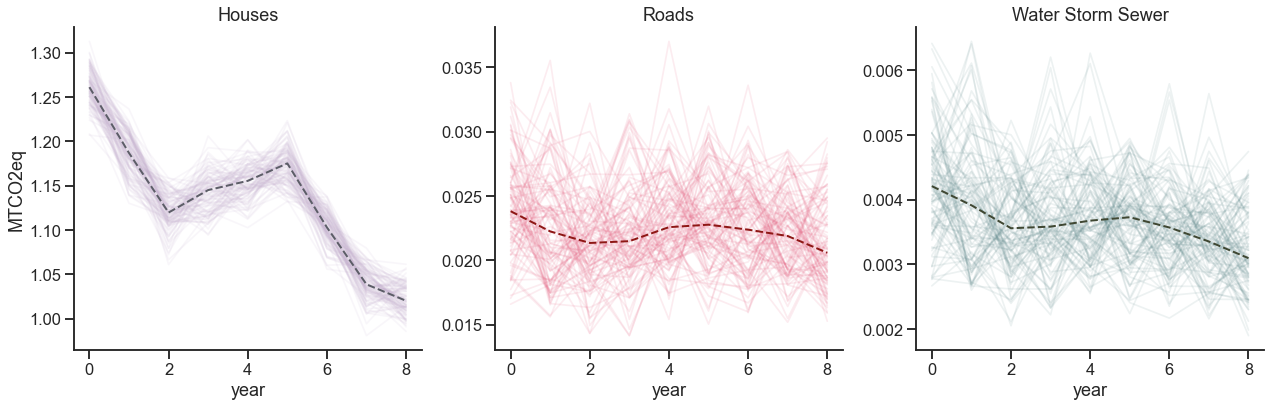

In [81]:
bic_scenario_c = pd.concat(full_inter)
bic_scenario_c = bic_scenario_c.join(prov_da[['DAUID','pop_2021']].set_index('DAUID'), on='DAUID')
bic_scenario_c['house_ghg'] = bic_scenario_c['house_ghg_pp']*bic_scenario_c['pop_2021']*10**-3
bic_scenario_c['road_ghg'] = bic_scenario_c['road_ghg_pp']*bic_scenario_c['pop_2021']*10**-3
bic_scenario_c['water_ghg'] = bic_scenario_c['water_inf_ghg_pp']*bic_scenario_c['pop_2021']*10**-3
bic_scenario_c = bic_scenario_c.drop(['house_ghg_pp','road_ghg_pp','water_inf_ghg_pp'], axis=1)
bic_scenario_c['house_road_ghg'] = bic_scenario_c['house_ghg'] + bic_scenario_c['road_ghg']
bic_scenario_c['all_ghg'] = bic_scenario_c['house_ghg'] + bic_scenario_c['road_ghg'] + bic_scenario_c['water_ghg']

# Plot outputs year by year.
fig, ax = plt.subplots(1,3, figsize=(18,6))
for i in range(0,200):
    plotr = bic_scenario_c[bic_scenario_c['iter'] == i].groupby('year').sum()
    sns.lineplot(ax=ax[0], data=plotr, x=plotr.index, y=plotr['house_ghg']*10**-6,#.cumsum(), 
                 color='#C3ACCE', alpha=0.1, linewidth=1.7)
    sns.lineplot(ax=ax[1], data=plotr, x=plotr.index, y=plotr['road_ghg']*10**-6,#.cumsum(), 
                 color='#E34A6F', alpha=0.1, linewidth=1.7)
    sns.lineplot(ax=ax[2], data=plotr, x=plotr.index, y=plotr['water_ghg']*10**-6,#.cumsum(),
                 color='#538083', alpha=0.1, linewidth=1.7)
    

# Plot median
plotr_m = bic_scenario_c.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
sns.lineplot(ax=ax[0], data=plotr_m, x=plotr_m.index, y=plotr_m['house_ghg']*10**-6,#.cumsum(), 
                color='#5C5D67', alpha=1, linewidth=2, linestyle='dashed')
sns.lineplot(ax=ax[1], data=plotr_m, x=plotr_m.index, y=plotr_m['road_ghg']*10**-6,#.cumsum(), 
                color='#8E1715', alpha=1, linewidth=2, linestyle='dashed')
sns.lineplot(ax=ax[2], data=plotr_m, x=plotr_m.index, y=plotr_m['water_ghg']*10**-6,#.cumsum(),
                color='#3F4732', alpha=1, linewidth=2, linestyle='dashed')


ax[0].spines[['top','right']].set_visible(False)
ax[1].spines[['top','right']].set_visible(False)
ax[2].spines[['top','right']].set_visible(False)
ax[0].set_ylabel('MTCO2eq')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_title('Houses')
ax[1].set_title('Roads')
ax[2].set_title('Water Storm Sewer')
#ax.set_ylabel('kgCO2eq/person')
plt.tight_layout()

### infill sensitivity
below I run the 2030 simulation with varying infill values and k values to create a 2-D surface for varying housing mixes

In [3]:
# Init full province loop variables: name, infill rate
abbrevation_name_list = ['nl','ns','nb','pei','qc','on','mb','sk','ab','bc',
                         #'yk','nwt'
                         ]
full_name_list = ['newfoundland','nova_scotia','new_brunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british_columbia',
                  #'yukon','nwt'
                  ]

infill_ps = [0.175, 0.175, 0.175, 0.175, 0.35, 0.35, 0.175, 0.175, 0.175, 0.35]
infill_ps1 = [0.35, 0.35, 0.35, 0.35, 0.70, 0.70, 0.35, 0.35, 0.35, 0.70]
infill_ps2 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
infill_list = [infill_ps2]#[infill_ps, infill_ps1, infill_ps2]
k_list = [0.2, 0.4, 0.6, 1.0]
names_k = ['_k_sense_2','_k_sense_4','_k_sense_6','_k_sense_8']
names_inf = ['_i_all']#['_i_norm','_i_d','_i_all']
htype_list = ['sf',]#'mm','mh']

for ht in htype_list:
    for v, infill_l in enumerate(infill_list):
        for u, ki in enumerate(k_list):
            # run full country loop
            full_short_term = []
            for i, name in enumerate(full_name_list):
                # init
                print(name)
                forecaster = Forecast()
                forecaster.province_name = name

                # import prep sample
                p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
                mc = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '.csv')
                samps_p = forecaster.prep_sample_with_imports_quantile(samp=mc, h_type=ht, q=0.95, iters=500)

                # get projected starts
                p_starter = ProjectStarts()
                s_starts = p_starter.provincial_starts(name)

                # run generic matflow - change '_d_add' to '_d' to  do BAU vs. high growth
                prov_f = forecaster.matflow_generic(samps_p=samps_p, starts=np.array(s_starts[0][name+'_d_add']),
                                                    it=100, infill_percent=infill_l[i], k=ki)
                
                full_short_term.append(prov_f)
                
            # save the run
            full_inter = []
            for full in full_short_term:
                full_inter.append(pd.concat(full))

            pd.concat(full_inter).set_index('DAUID').to_csv(ht+names_inf[v]+names_k[u]+'.csv')    
    


newfoundland
[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55
quantile percentage:  1.0


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.9863013698630136


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.9863013698630136


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.9863013698630136


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.9863013698630136


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


  0%|          | 0/9 [00:00<?, ?it/s]

year:  0
building new...
infilling...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
bui

#### Infill sensitivity: best-case scenario
run the infill and circularity sensitivity with all of the strategies applied: best-in-class design, material technology, and high missing middle

In [8]:
# Init full province loop variables: name, infill rate
abbrevation_name_list = ['nl','ns','nb','pei','qc','on','mb','sk','ab','bc',
                         #'yk','nwt'
                         ]
full_name_list = ['newfoundland','nova_scotia','new_brunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british_columbia',
                  #'yukon','nwt'
                  ]

# sensitivity inputs for the code below
# NEED TO RUN EACH INFILL SCENARIO FOR THE VARIABLES TO GET THE 2-D SENSITIVITY
# ALSO NEED TO RUN D_ADD AND D
infill_ps = [0.175, 0.175, 0.175, 0.175, 0.35, 0.35, 0.175, 0.175, 0.175, 0.35]
infill_ps1 = [0.35, 0.35, 0.35, 0.35, 0.70, 0.70, 0.35, 0.35, 0.35, 0.70]
infill_ps2 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
infill_list = [infill_ps2]#[infill_ps, infill_ps1, infill_ps2]
k_list = [0.2, 0.4, 0.6, 1.0]

# names for naming the file
names_k = ['_k_sense_2','_k_sense_4','_k_sense_6','_k_sense_8']
names_inf = ['_i_all']#['_i_norm','_i_d','_i_all']
htype_list = ['mm',]#'mm','mh']

for ht in htype_list:
    for v, infill_l in enumerate(infill_list):
        for u, ki in enumerate(k_list):
            # run full country loop
            full_short_term = []
            for i, name in enumerate(full_name_list):
                # init
                print(name)
                forecaster = Forecast()
                forecaster.province_name = name

                # get projected starts
                p_starter = ProjectStarts()
                s_starts = p_starter.provincial_starts(name)
                # run generic matflow - change '_d_add' to '_d' to  do BAU vs. high growth
                # transform to just the base year, run d and d_add: 
                starts_uno = s_starts[0].loc[2029:2030][name+'_d_add']

                # get prov_da for province, clean roads
                hs = HouseSample(master=forecaster.master)
                hs.province_name = forecaster.province_name
                prov_da = hs.get_prov_da(prov_name=forecaster.province_name, shapefile_path=hs.shapefile_path, 
                                            census_data_path=hs.path + 'da_census_data_reduced/' + hs.prov_da_file_map[forecaster.province_name], dropna=True)

                # road clean filter extreme outliers
                rc = RoadClean(master=forecaster.master)
                rc.province_name = forecaster.province_name
                roads_clean = rc.full_road_clean_map()
                road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})
                handy = Helper()
                road_filt = handy.drop_outliers_iqr(road_filt, 'LENGTH_GEO', f=3)

                # the normal import acts as the 2022 sample
                # DON'T NEED THE BASE YEAR JUST DOING 2030 SO COMMENT OUT
                # import prep sample
                #p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
                #mc2022 = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '_bic.csv')
                #samps_p2022 = forecaster.prep_sample_quantile(samp=mc2022, n_iters=500, prov_da=prov_da, road_filter_index=road_filt.index, 
                #                                            h_type=house_type_quant, q=0.95)

                # import and prep sample for every year of the sim
                p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
                mc_list = []
                for year_str in s_starts[0][1:].index:
                    mcy = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '_bic_' + str(year_str) + '.csv')
                    samps_p = forecaster.prep_sample_quantile(samp=mcy, n_iters=100, prov_da=prov_da, road_filter_index=road_filt.index, 
                                                              h_type=ht, q=0.95)
                    mc_list.append(samps_p)

                #mc_list.insert(0, samps_p2022) # BASE YEAR COMMENT OUT
                prov_f = forecaster.matflow_yearly(samps_pl=mc_list, starts=np.array(starts_uno),
                                                   it=100, infill_percent=infill_l[i], k=ki)
                
                full_short_term.append(prov_f)
                            
            # save the run
            full_inter = []
            for full in full_short_term:
                full_inter.append(pd.concat(full))

            pd.concat(full_inter).set_index('DAUID').to_csv('best_case_'+ht+names_inf[v]+names_k[u]+'_2030_add.csv')    


newfoundland


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  29
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  3
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  918
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  1937
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  205
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  341
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  675
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  496
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  29
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  3
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  918
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  1937
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


manitoba
[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  205
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  341
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  675
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  496
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


new_brunswick
[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  29
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  3
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  918
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  1937
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  205
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  341
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  675
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  496
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  55
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714
quantile percentage:  0.771785714285714


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  29
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  3
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  918
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  1937
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  205
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  341
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  675
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  496
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877


  0%|          | 0/2 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
building iter:  50
building iter:  

In [3]:
# get projected starts -> we only need to run 2030
# get projected starts
p_starter = ProjectStarts()
s_starts = p_starter.provincial_starts('nova_scotia')
# transform to just the base year, run d and d_add: 
starts_uno = s_starts[0].loc[2029:2030]['nova_scotia'+'_d_add']

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


In [5]:
starts_uno.index

Int64Index([2029, 2030], dtype='int64', name='Year')

## Canada Long-Term Forecast
run the analysis for different population growth scenarios, fixed vs varying household formation rate. Strategies to explore at mat reduction to net zero, mat reduction to just 2030, maybe best in class design. Try and see if you can do a BAU housing mix or just average the single family and the missing middle. <b> historic Canada housing starts since 2010: ~ 33% 33% 33% spit between single family midhigh and missing middle</b>

In [76]:
# get projected starts
p_starter = ProjectStarts()
s_starts = p_starter.provincial_starts('nova_scotia')

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


In [81]:
np.array(s_starts[1].iloc[:,1:].columns)
#s_starts[1]
#s_starts[1][pop_scenario][:-1]

array(['Projection scenario LG: low-growth',
       'Projection scenario M1: medium-growth',
       'Projection scenario M2: medium-growth',
       'Projection scenario M3: medium-growth',
       'Projection scenario M4: medium-growth',
       'Projection scenario M5: medium-growth',
       'Projection scenario M6: medium-growth',
       'Projection scenario HG: high-growth',
       'Projection scenario SA: slow-aging',
       'Projection scenario FA: fast-aging'], dtype=object)

In [140]:
# Init full province loop variables: name, infill rate
# newfoundland excluded, it has no growth!
abbrevation_name_list = ['ns','nb','pei','qc','on','mb','sk','ab','bc',
                         #'yk','nwt'
                         ]
full_name_list = ['nova_scotia','new_brunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british_columbia',
                  #'yukon','nwt'
                  ]

infill_ps = [0.175, 0.175, 0.175, 0.35, 0.35, 0.175, 0.175, 0.175, 0.35]
infill_ps_doub = [0.35, 0.35, 0.35, 0.7, 0.7, 0.35, 0.35, 0.35, 0.7]
house_type_quant = 'mm'

# run full country loop
full_long_term = []
for i, name in enumerate(full_name_list):
    # init
    print(name)
    forecaster = Forecast()
    forecaster.province_name = name

    # get projected starts
    p_starter = ProjectStarts()
    s_starts = p_starter.provincial_starts(name)

    # get prov_da for province, clean roads
    hs = HouseSample(master=forecaster.master)
    hs.province_name = forecaster.province_name
    prov_da = hs.get_prov_da(prov_name=forecaster.province_name, shapefile_path=hs.shapefile_path, 
                                census_data_path=hs.path + 'da_census_data_reduced/' + hs.prov_da_file_map[forecaster.province_name], dropna=True)

    # road clean filter extreme outliers
    rc = RoadClean(master=forecaster.master)
    rc.province_name = forecaster.province_name
    roads_clean = rc.full_road_clean_map()
    road_filt = roads_clean.groupby('DAUID').agg({'LENGTH_GEO':np.sum})
    handy = Helper()
    road_filt = handy.drop_outliers_iqr(road_filt, 'LENGTH_GEO', f=3)

    # import and prep sample for every year of the sim
    p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/mc_samples/'
    mc_list = []
    for year_str in s_starts[1]['year'][:-1]:
        #mcy = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '_' + str(year_str) + '.csv')
        mcy = pd.read_csv(p + abbrevation_name_list[i] + '/inf_mc_samples_' + abbrevation_name_list[i] + '_2030' + '.csv')
        samps_p = forecaster.prep_sample_quantile(samp=mcy, n_iters=100, prov_da=prov_da, road_filter_index=road_filt.index, 
                                                  h_type=house_type_quant, q=0.95)
        mc_list.append(samps_p)

    # run generic matflow - we want to run for every population scenario and store them individually
    prov_scenarios = {}
    for pop_scenario in np.array(s_starts[1].iloc[:,1:].columns):
        prov_f = forecaster.matflow_yearly(samps_pl=mc_list, starts=np.array(s_starts[1][pop_scenario][:-1]),
                                           it=50, infill_percent=infill_ps[i], k=0.8)  # change k value and infill list here!!
        prov_scenarios[pop_scenario] = prov_f

    full_long_term.append(prov_scenarios)



nova_scotia


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_sample\road_clean_sample.py:50: DtypeWarning: Columns (10,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  province = pd.read_csv(self.path+road_file_name_map[province_name])



Import-clean complete. Returning.
dropped:  22
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125
quantile percentage:  0.7578125


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
year:  1
year:  2
year:  3
year:  4
year:  5
year:  6
year:  7
year:  8
year:  9
year:  10
year:  11
year:  12
year:  13
year:  14
year:  15
year:  16
year:  17
year:  18


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
year:  1
year:  2
year:  3
year:  4
year:  5
year:  6
year:  7
year:  8
year:  9
year:  10
year:  11
year:  12
year:  13
year:  14
year:  15
year:  16
year:  17
year:  18
new_brunswick


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  29
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787
quantile percentage:  0.805851063829787


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
year:  1
year:  2
year:  3
year:  4
year:  5
year:  6
year:  7
year:  8
year:  9
year:  10
year:  11
year:  12
year:  13
year:  14
year:  15
year:  16
year:  17
year:  18


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
year:  1
year:  2
year:  3
year:  4
year:  5
year:  6
year:  7
year:  8
year:  9
year:  10
year:  11
year:  12
year:  13
year:  14
year:  15
year:  16
year:  17
year:  18
pei


c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  3
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896
quantile percentage:  0.8063892864444896


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  918
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0
quantile percentage:  1.0


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  1937
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571
quantile percentage:  0.8571428571428571


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  205
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743
quantile percentage:  0.7017021276595743


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  341
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706
quantile percentage:  0.6753216911764706


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  675
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718
quantile percentage:  0.8717948717948718


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

c:\Users\Keagan Rankin\OneDrive - University of Toronto\Saxe - Rankin\Project 2. Housing Projections\FIG_Canada\model\fig_package\fig_project\project_starts.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pop_proj = pd.read_csv(self.path+'canada population projections/17100057.csv')


[I] Reading DA Shapefile...
[I] Importing census data...
[I] Merging data...
[I] Adding useful columns...
[C] Returning... Complete.
Cleaning road data...

Import-clean complete. Returning.
dropped:  496
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877
quantile percentage:  0.9591836734693877


  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

  0%|          | 0/19 [00:00<?, ?it/s]

year:  0
building new...
building iter:  0
building iter:  1
building iter:  2
building iter:  3
building iter:  4
building iter:  5
building iter:  6
building iter:  7
building iter:  8
building iter:  9
building iter:  10
building iter:  11
building iter:  12
building iter:  13
building iter:  14
building iter:  15
building iter:  16
building iter:  17
building iter:  18
building iter:  19
building iter:  20
building iter:  21
building iter:  22
building iter:  23
building iter:  24
building iter:  25
building iter:  26
building iter:  27
building iter:  28
building iter:  29
building iter:  30
building iter:  31
building iter:  32
building iter:  33
building iter:  34
building iter:  35
building iter:  36
building iter:  37
building iter:  38
building iter:  39
building iter:  40
building iter:  41
building iter:  42
building iter:  43
building iter:  44
building iter:  45
building iter:  46
building iter:  47
building iter:  48
building iter:  49
infilling...
building iter:  0
buil

In [141]:
name_list = ['Projection scenario LG', 'Projection scenario M1', 'Projection scenario M2', 'Projection scenario M3', 'Projection scenario M4', 'Projection scenario M5',
             'Projection scenario M6', 'Projection scenario HG','Projection scenario SA', 'Projection scenario FA']

for j, sce in enumerate(np.array(s_starts[1].iloc[:,1:].columns)):
    scenario_canada = []
    for i in range(0,9):
        # skip the empty arrays where we build nothing
        if full_long_term[i][sce]:
            scenario_prov = pd.concat(full_long_term[i][sce])
            scenario_canada.append(scenario_prov)

    pd.concat(scenario_canada).to_csv('mm_lockin_'+name_list[j]+'.csv')

In [118]:
if full_long_term[4][sce]: 
    print('foo')

foo


In [131]:
pd.concat(full_long_term[5][sce])

DAUID  house_ghg_pp  road_ghg_pp  water_inf_ghg_pp  iter  \
48294  46110301  15062.774217   842.669258        140.865190     0   
4388   46090049  12759.883795  4424.185230        132.880972     0   
34273  46110682  13163.025498   572.761007         74.927082     0   
45951  46110601  13811.367415    20.755759        122.147512     0   
97177  46110661  14371.631400   510.520634         72.986364     0   
...         ...           ...          ...               ...   ...   
53680  46111150     29.027504     0.000000          0.000000    45   
68242  46070121     51.011183     0.000000          0.000000    46   
26335  46110572     27.458615     0.000000          0.000000    47   
1576   46111125     35.155554     0.000000          0.000000    48   
77018  46111018     27.238752     0.000000          0.000000    49   

       tot_pd_check_count  year  
48294               690.0     0  
4388                235.0     0  
34273               290.0     0  
45951               410.0     0  
97177               225.0     0  
...                   ...   ...  
53680               805.0    18  
68242               275.0    18  
26335               470.0    18  
1576                290.0    18  
77018               180.0    18  

[9393 rows x 7 columns]

In [107]:
pd.concat(scenario_canada)

DAUID  house_ghg_pp  road_ghg_pp  water_inf_ghg_pp  iter  \
68277   12090995  16187.213543  4337.847352        194.227200     0   
178     12060174  20280.111732  3882.273539        219.632278     0   
74752   12120126  21898.758019  1194.406259        109.017938     0   
4719    12090659  17961.463825  1799.607918        203.745746     0   
79210   12090785  16991.756197  1356.417236        224.810147     0   
...          ...           ...          ...               ...   ...   
142213  59410254     74.592289     0.000000          0.000000    49   
351164  59210457     82.082166     0.000000          0.000000    49   
387     59090727     86.196206     0.000000          0.000000    49   
344342  59260344     85.132821     0.000000          0.000000    49   
291945  59151128     56.883524     0.000000          0.000000    49   

        tot_pd_check_count  year  
68277                185.0     0  
178                  105.0     0  
74752                160.0     0  
4719                 200.0     0  
79210                130.0     0  
...                    ...   ...  
142213                30.0    18  
351164               235.0    18  
387                  405.0    18  
344342               245.0    18  
291945                85.0    18  

[781253 rows x 7 columns]

In [30]:
# Save results
# size should be ~1/2 GB for each of the four scenarios: sf vs. mm, to net zero vs. maxed out material reductions.
full_inter = []
for full in full_short_term:
    full_inter.append(pd.concat(full))

#pd.concat(full_inter).to_csv('lt_m2_sf_netzero.csv')#.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)['tot_pd_check_count'].sum()